# Video: Visualizing the LinUCB Algorithm

The LinUCB algorithm was the first broadly used linear bandit algorithm.
This video will show how the underlying linear model shares data across contexts.

## LinUCB for Linear Contextual Bandits

* LinUCB was one of the first algorithms for linear contextual bandits.
* As a linear bandit, LinUCB assumes the expected reward is a linear combination of input features.
* For example, $0.3 * \mathrm{\#strawberry} + 0.3 * \mathrm{\#pie}$...
* Will write as $\theta^\mathrm{T} \mathbf{z}$

Script:
* LinUCB was the first linear bandit algorithm to get broad usage.
* There were previous linear bandit algorithms, but LinUCB performed better and was widely adopted.
* The first assumption of LinUCB is that the underlying reward distributions have an expected value that is a linear function of the context.
* That is the core assumption of all linear bandits.
* We represent this linear function with the parameter vector $\theta$ and compute the expected value by taking the dot product with the context vector $\mathbf{z}$.

## LinUCB Upper Bounds

LinUCB has one hyperparameter $\delta$ for the probability the upper bound is not an overestimate...

\begin{array}{rcl}
\alpha & = & 1 + \sqrt{\ln(2 / \delta)/2} \\
\mathbf{D} & = & \text{matrix of rows of previous context vectors} \\
\hat{\theta} & = & \text{estimate for $\theta$ using ridge regression} \\
\mathbf{z} & = & \text{new constant vector} \\
\text{upper bound} & = & \mathbf{z}^\mathrm{T} \hat{\theta} + \alpha \sqrt{\mathbf{z}^\mathrm{T} \left(\mathbf{D}^\mathrm{T} \mathbf{D} + \mathbf{I}_d \right)^{-1} \mathbf{z}}
\end{array}


Script:
* LinUCB has one tuning parameter $\delta$ representing the probability that the bound is mistaken.
* From $\delta$, you calculate another parameter $\alpha$ to get an upper bound meeting the $\delta$ failure rate bound.
* The formula is based on Bayesian analysis and the covariance of the estimate, but you don't need to learn this formula; just look it up as needed.
* How should $\delta$ be picked?
* Most practitioners actually skip $\delta$ and go straight to picking an $\alpha$ value between 0.1 and 1.0.
* These $\alpha$ values are actually lower than you would get picking $\delta$ between 0 and 1, but empirically, the upper bound tends to be loose so lower $\alpha$ values can often be justified from checking some training data.

## Experiment Setup

Context dimensions
* All 0-1 variables.
* 1 if tag present. 0 otherwise.

Training contexts:
* #apple #crisp
* #apple #strudel
* #apple #pie
* #peach #pie

Test context: (maybe show to the right of training contexts)
* #peach #crisp

Script:
* The experiment that I setup to demonstrate LinUCB uses a number of 0-1 values representing tags for the context vectors.
* LinUCB is not restricted to 0-1 values; that was just my choice for this experiment.
* To make it easier to see what's going on, I will keep the set of contexts fixed while running this simulation, and LinUCB will keep picking from the same contexts.
* This is less dynamic than most contextual bandit contexts, but will make it easier for you to see the bounds and estimates change.

In [ ]:
import math

import numpy as np
import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [ ]:
np.random.seed(704)

T_max = 1000

# true coefficients and dimension setup

theta_true = {'apple': 0.4,
              'crisp': 0.4,
              'peach': 0.3,
              'pie': 0.3,
              'strudel': 0.2}

dimensions = sorted(theta_true.keys())
dimensions_index = {dimensions[i] for (i, d) in enumerate(dimensions)}

theta_true_vector = [theta_true[d] for d in dimensions]
theta_true_vector = np.array(theta_true_vector)

# context setup

def context_to_vector(context):
    return np.array([1 if d in context else 0 for d in dimensions])

training_contexts = [['apple', 'crisp'], ['apple', 'strudel'], ['apple', 'pie'], ['peach', 'pie']]
training_context_vectors = [context_to_vector(c) for c in training_contexts]
training_context_vectors = np.array(training_context_vectors)

training_colors = ["blue", "orange", "green", "red", "purple"]

test_context = ['peach', 'crisp']
test_context_vector = context_to_vector(test_context)

# following Algorithm 1 of Li et al, A Conceptual-Bandit
# Approach to Personalized News Article Recommendation, 2010

delta = 0.1
alpha = 1 + math.sqrt(math.log(2 / delta) / 2)

A = np.eye(len(dimensions)) # incremental computation of D^\mathrm{T} D + I
A_inv = A
b = np.zeros(len(dimensions)) # incremental computation of D^\mathrm{T} c
theta_hat = np.zeros(len(dimensions)) # latest coefficient estimate

theta_hat_history = np.zeros((T_max, len(dimensions)))
training_bounds_history = np.zeros((T_max, len(training_contexts)))
training_estimates_history = np.zeros((T_max, len(training_contexts))) # for plots
training_rewards_history = np.zeros(T_max) # for plots
training_choices_history = np.zeros(T_max, dtype=int)
test_bound_history = np.zeros(T_max)

def sample_context(context_vector):
    # expected value from true linear model
    r = theta_true_vector.T @ context_vector

    # add some noise
    r += np.random.normal(0.0, 0.1)

    return r

def calculate_bound(context_vector):
    expected_reward = theta_hat @ context_vector
    return expected_reward + alpha * np.sqrt(context_vector @ np.linalg.inv(A) @ context_vector)

c = np.zeros(T_max)

for t in range(T_max):
    # update coefficients estimate
    theta_hat[:] = np.linalg.inv(A) @ b

    theta_hat_history[t,:] = theta_hat

    # save estimates for plotting

    training_estimates_history[t,:] = theta_hat @ training_context_vectors.T

    # calculate training bounds

    training_bounds = [calculate_bound(c) for c in training_context_vectors]
    training_bounds_history[t,:] = training_bounds

    test_bound = calculate_bound(test_context_vector)
    test_bound_history[t] = test_bound

    # pick arm

    j = np.argmax(training_bounds)
    training_choices_history[t] = j

    # record chosen context
    #print(training_contexts[j], training_estimates_history[t,j])

    current_context_vector = training_context_vectors[j]

    # record sampled reward

    r = sample_context(current_context_vector)
    training_rewards_history[t] = r

    # update model

    A = A + np.outer(current_context_vector, current_context_vector)
    A_inv = np.linalg.inv(A)
    b = b + r * current_context_vector


In [ ]:
# selected context estimates

fig = plt.figure(figsize=(19.2, 10.8), dpi=100)
ax = plt.axes(xlim=0, ylim=0)

artists = []
for j in range(len(training_contexts)):
    line, = ax.plot([], [],
                    label=" ".join(training_contexts[j]) + " estimate",
                    linestyle="none",
                    marker="x")
    artists.append(line)

artists.append(plt.legend())

def init():
    return artists

def animate(i):
    for j in range(len(training_contexts)):
        selected_times = [t for t in range(i) if training_choices_history[t] == j]

        artists[j].set_data(selected_times,
                            training_estimates_history[selected_times,j])

    plt.title("Estimates of Selected Actions")
    plt.xlim(0, i+1)
    plt.ylim(0)

    return artists

selected_estimates_anim = FuncAnimation(fig, func=animate, init_func=init, frames=250, interval=200)

# extra args to enable HTML embedding
selected_estimates_anim.save("selected-estimates.mp4", fps=30, extra_args=['-vcodec', 'libx264']);

plt.close(fig)

## Play this Video Please


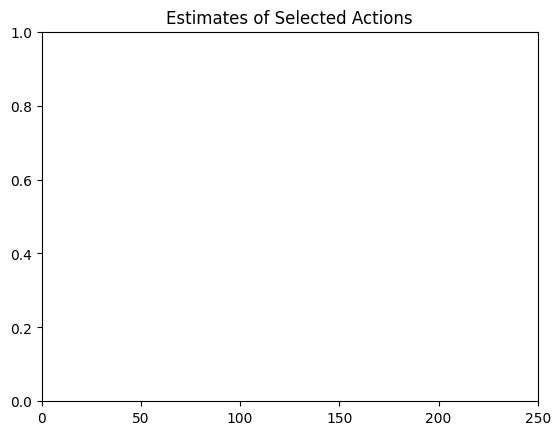

In [ ]:
HTML(selected_estimates_anim.to_html5_video())

Script:
* Here you can see the bandit picking from the different contexts.
* Early on you can see it picking pretty evenly, but it pretty quickly starts differentiating its estimates for each context.
* At that point, it starts picking apple crisp more consistently.
* Which is of course the right answer for which one is best.
* But it still keeps trying the others occasionally.

## Checking the Upper Confidence Bounds


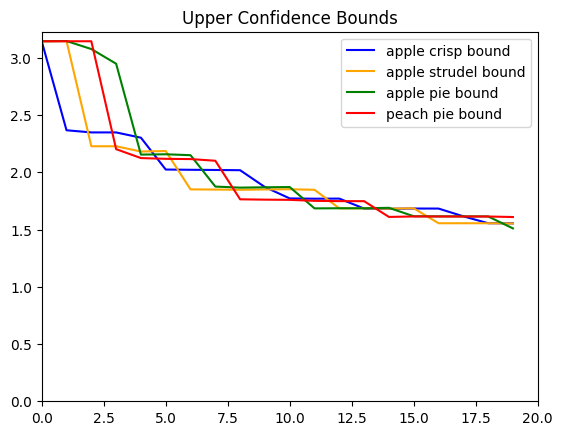

In [ ]:
def plot_bounds(T, test=False):
    for j in range(len(training_contexts)):
        plt.plot(range(T),
                training_bounds_history[:T,j],
                color=training_colors[j],
                label=" ".join(training_contexts[j]) + " bound")

    if test:
        plt.plot(range(T),
                test_bound_history[:T],
                color="black",
                label=" ".join(test_context) + " bound (test)",
                linestyle="dashed")

    plt.legend()
    plt.title("Upper Confidence Bounds")
    plt.xlim(0, T)
    plt.ylim(0)
    plt.show();

plot_bounds(20)

Script:
* If we plot the upper confidence bounds like we did with UCB1 before, then we see a similar pattern where the bounds fall together, and take turns being highest.
* One thing that is different from UCB1 is that the bounds for unselected actions are not always going up.
* It is possible for them to go up, especially if one of the parameters was mis-estimated early on, but the bounds calculation here is rooted in the estimate variance, not in time.
* One more thing to notice is that the bounds can go down even when a context is not selected, but they tend to go down more when they are first selected.
* That happened for each of the four training contexts.

## Upper Confidence Bounds for the Test Context


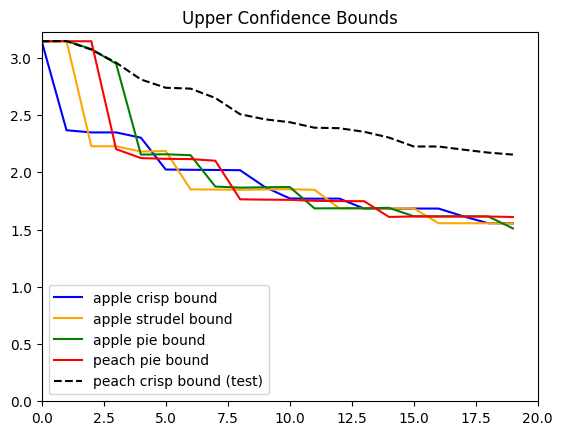

In [ ]:
plot_bounds(20, test=True)

Script:
* If we add the test context too, we see that its bound is also decreasing over time despite it never being selected.
* This is because the underlying variables are included in the selected contexts, so confidence in those coefficients is improving over time.

## Long Term Upper Confidence Bounds


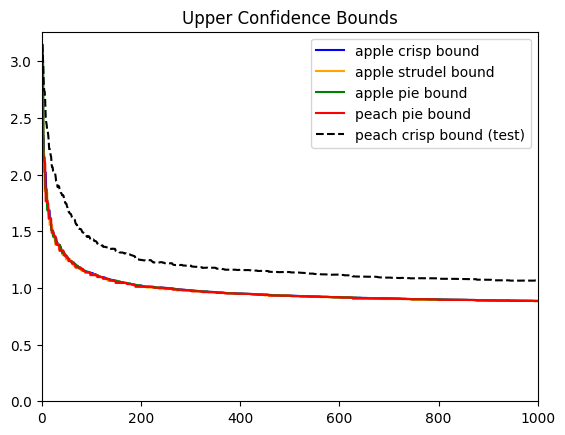

In [ ]:
plot_bounds(T_max, test=True)

Script:
* If we zoom out, we see the same trend continue.
* The training contexts all decrease their bounds in lockstep, and the test context tends to improve, but stays visibly behind.
* So it was offered as an option, it would probably be explored once or twice and then behave similarly to the rest.
* Also note that despite that current gap, its bounds are much lower than at the beginning of the experiment.
* Perhaps you are also thinking that test bound looks pretty loose.
* You would be right; there are more sophisticated linear bandit algorithms that can give better bounds.
* However, we start with LinUCB since it was the first linear bandit algorithm that worked well enough for wide usage, and still is the dominant choice.

## Training Rewards


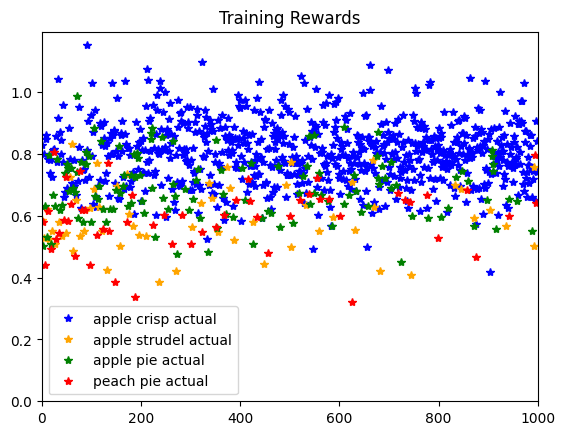

In [ ]:
for j in range(len(training_contexts)):
    selected_times = [i for i in range(T_max) if training_choices_history[i] == j]
    plt.plot(selected_times,
             training_rewards_history[selected_times],
             color=training_colors[j],
             label=" ".join(training_contexts[j]) + " actual",
             linestyle="none",
             marker="*")

plt.legend()
plt.title("Training Rewards")
plt.xlim(0, T_max)
plt.ylim(0)
plt.show();

Script:
* In case you are wondering why the lesser contexts are chosen so often, here is a chart of the training rewards in the experiment.
* When setting up the rewards, I included a significant amount of rewards, so the ranges do overlap significantly.
* Despite that, the linear bandit still has a pretty good estimate for the rewards of each context and is focused on the true best context.
* So even though I just said that there are better linear bandit algorithms, it is doing pretty well here and it has good reason to still be considering the other choices.

Script: (faculty on camera)
* I hope this video helped with your intuition for how LinUCB works.
* LinUCB has been a very popular bandit implementation since it is pretty simple to implement and gets the job done.


https://github.com/bu-cds-omds/dx704-examples/blob/main/week04/video_visualizing_the_linucb_algorithm.ipynb